<a href="https://colab.research.google.com/github/vlordier/colabs/blob/main/model6(Personality_Prediction)_Notebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/yashsmehta/personality-prediction.git

Cloning into 'personality-prediction'...
remote: Enumerating objects: 818, done.
remote: Counting objects: 100% (818/818), done.
remote: Compressing objects: 100% (424/424), done.
remote: Total 818 (delta 501), reused 659 (delta 376), pack-reused 0
Receiving objects: 100% (818/818), 50.57 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [ ]:
!pip install preprocessor


  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4477 sha256=b3cba6ade753511f01be628dcea13ce040c4173412db26864e013e90570a9be8
  Stored in directory: /root/.cache/pip/wheels/0e/b7/36/aa37256db62b4bfd35a6f1b5536e9ba843f257b79dcbf3d5f1
Successfully built preprocessor


# **MLP_psycho_features based Personality Prediction**

In [ ]:

def read_and_process(path):
    arff = open(path, "r")
    attributes = []
    values = []
    is_attr = True
    arff.readline()
    arff.readline()
    while is_attr:
        line = arff.readline()
        if len(line.split()) == 0:
            is_attr = False
            continue
        type = line.split()[0]
        attr = " ".join(line.split()[1:])
        if type == "@attribute":
            attributes.append(attr)
        else:
            is_attr = False
    for line in arff.readlines():
        if len(line.split(",")) < 10:
            continue
        else:
            components = line.split(",")
            values.append(components)
            name = components[0].replace("'", "").split("\\\\")[-1]
            values[-1][0] = name
    df = pd.DataFrame(columns=attributes, data=values)
    df["idx"] = [int(re.sub("id_", "", i)) for i in df[df.columns[0]]]
    df = df.drop(df.columns[0], axis=1)
    df = df.set_index(["idx"])
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.sort_index()
    return df


def sentence_preprocess(sentence):
    sentence = p.clean(sentence)
    # Remove hyperlinks
    sentence = re.sub(r"http\S+", " ", sentence)
    # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub("[^a-zA-Z.?!,]", " ", sentence)
    # Single character removal (except I)
    sentence = re.sub(r"\s+[a-zA-HJ-Z]\s+", " ", sentence)
    # Removing multiple spaces
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence


def load_features(dir, dataset):
    idx = "id"
    if dataset == "kaggle":
        drop_cols = [
            "BROWN-FREQ numeric",
            "K-F-FREQ numeric",
            "K-F-NCATS numeric",
            "K-F-NSAMP numeric",
            "T-L-FREQ numeric",
            "Extraversion numeric",
            "'Emotional stability' numeric",
            "Agreeableness numeric",
            "Conscientiousness numeric",
            "'Openness to experience' numeric",
        ]
        mairesse = read_and_process(dir + dataset + "_mairesse_labeled.arff")
        mairesse = mairesse.drop(drop_cols, axis=1)
    elif dataset == "essays":
        idx = "#AUTHID"
        mairesse = pd.read_csv(dir + dataset + "_mairesse_labeled.csv")
        mairesse = mairesse.set_index(mairesse.columns[0])
    nrc = pd.read_csv(dir + dataset + "_nrc.csv").set_index([idx])
    # nrc = nrc.sort_values(by=['id'])
    # nrc = nrc.drop(['id'], axis=1)
    nrc_vad = pd.read_csv(dir + dataset + "_nrc_vad.csv").set_index([idx])
    # nrc_vad = nrc_vad.sort_values(by=['id'])
    # nrc_vad = nrc_vad.drop(['id'], axis=1)
    # affectivespace = pd.read_csv(dir + 'essays_affectivespace.csv').set_index(['#AUTHID'])
    # hourglass = pd.read_csv(dir + dataset + '_hourglass.csv').set_index([idx])
    readability = pd.read_csv(dir + dataset + "_readability.csv").set_index([idx])

    return [nrc, nrc_vad, readability, mairesse]

def get_psycholinguist_data(dump_data, dataset, feature_flags):
    features = load_features(
        "/content/personality-prediction/data/" + dataset + "/psycholinguist_features/", dataset
    )

    first = 1
    for feature, feature_flag in zip(features, feature_flags):
        if feature_flag:
            if first:
                df = feature
                first = 0
            else:
                df = pd.merge(df, feature, left_index=True, right_index=True)
    if dataset == "essays":
        labels = dump_data[["user", "EXT", "NEU", "AGR", "CON", "OPN"]]
    if dataset == "kaggle":
        labels = dump_data[["user", "E", "N", "F", "J"]]
    labels = labels.set_index("user")
    if dataset == "kaggle":
        labels.index = pd.to_numeric(labels.index, errors="coerce")
        df.index = pd.to_numeric(df.index, errors="coerce")
    merged = pd.merge(df, labels, left_index=True, right_index=True).fillna(0)
    label_size = labels.shape[1]
    data = merged[merged.columns[: (-1 * label_size)]].values
    full_targets = merged[merged.columns[(-1 * label_size) :]].values
    feature_names = merged.columns
    return data, full_targets, feature_names, merged
import os
# importing sys
import sys
sys.path.insert(0, '/content/personality-prediction')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import time
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import utils.gen_utils as utils
import utils.dataset_processors as dataset_processors
#import utils.linguistic_features_utils as feature_utils


def get_inputs(dataset):
    """Read data from metafeature files and prepare for training."""

    nrc, nrc_vad, readability, mairesse = [True, True, True, True]
    feature_flags = [nrc, nrc_vad, readability, mairesse]
    if dataset == "essays":
        dump_data = dataset_processors.load_essays_df("/content/personality-prediction/data/essays/essays.csv")
        trait_labels = ["EXT", "NEU", "AGR", "CON", "OPN"]
    elif dataset == "kaggle":
        dump_data = dataset_processors.load_Kaggle_df("/content/personality-prediction/data/kaggle/kaggle.csv")
        trait_labels = ["E", "N", "F", "J"]
    print("dataset loaded! Getting psycholinguistic features...")
    inputs, full_targets, _, _ = get_psycholinguist_data(
        dump_data, dataset, feature_flags
    )
    inputs = np.array(inputs)
    full_targets = np.array(full_targets)

    return inputs, full_targets, trait_labels


def training(inputs, full_targets, trait_labels):
    """Train MLP model for each trait on 10-fold corss-validtion."""
    n_splits = 10
    expdata = {}
    expdata["acc"], expdata["trait"], expdata["fold"] = [], [], []

    for trait_idx in range(full_targets.shape[1]):
        # convert targets to one-hot encoding
        targets = full_targets[:, trait_idx]
        expdata["trait"].extend([trait_labels[trait_idx]] * n_splits)
        expdata["fold"].extend(np.arange(1, n_splits + 1))
        skf = StratifiedKFold(n_splits=n_splits, shuffle=False)
        k = -1

        for train_index, test_index in skf.split(inputs, targets):
            x_train, x_test = inputs[train_index], inputs[test_index]
            y_train, y_test = targets[train_index], targets[test_index]
            # converting to one-hot embedding
            y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
            y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
            model = tf.keras.models.Sequential()

            # define the neural network architecture
            model.add(
                tf.keras.layers.Dense(50, input_dim=features_dim, activation="relu")
            )
            model.add(tf.keras.layers.Dense(n_classes))

            k += 1
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["mse", "accuracy"],
            )
            history = model.fit(
                x_train,
                y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, y_test),
                verbose=0,
            )
            expdata["acc"].append(100 * max(history.history["val_accuracy"]))
    print(expdata)
    df = pd.DataFrame.from_dict(expdata)

    preds=model.predict(x_test)

    return df,preds, y_test



def logging(df, log_expdata=True):
    """Save results and each models config and hyper parameters."""
    (
        df["network"],
        df["dataset"],
        df["lr"],
        df["batch_size"],
        df["epochs"],
        df["model_input"],
        df["embed"],
        df["layer"],
        df["mode"],
        df["embed_mode"],
        df["jobid"],
    ) = (
        network,
        dataset,
        lr,
        batch_size,
        epochs,
        MODEL_INPUT,
        embed,
        layer,
        mode,
        embed_mode,
        jobid,
    )

    pd.set_option("display.max_columns", None)
    print(df.head(5))

    # save the results of our experiment
    if log_expdata:
        Path(path).mkdir(parents=True, exist_ok=True)
        if not os.path.exists(path + "expdata.csv"):
            df.to_csv(path + "expdata.csv", mode="a", header=True)
        else:
            df.to_csv(path + "expdata.csv", mode="a", header=False)


if __name__ == "__main__":
    sys.argv=['']
    del sys
    (
        inp_dir,
        dataset,
        lr,
        batch_size,
        epochs,
        log_expdata,
        embed,
        layer,
        mode,
        embed_mode,
        jobid,
    ) = utils.parse_args()

    features_dim = 123
    MODEL_INPUT = "psycholinguist_features"
    layer = ""
    path = "explogs/"
    n_classes = 2
    network = "MLP"
    print(network)

    np.random.seed(jobid)
    tf.random.set_seed(jobid)

    start = time.time()
    inputs, full_targets, trait_labels = get_inputs(dataset)
    print("starting k-fold cross validation...")
    df,preds,y_test = training(inputs, full_targets, trait_labels)
    logging(df, log_expdata)


MLP
EXT :  1    1275
0    1192
Name: EXT, dtype: int64
NEU :  1    1234
0    1233
Name: NEU, dtype: int64
AGR :  1    1309
0    1158
Name: AGR, dtype: int64
CON :  1    1254
0    1213
Name: CON, dtype: int64
OPN :  1    1271
0    1196
Name: OPN, dtype: int64
dataset loaded! Getting psycholinguistic features...
starting k-fold cross validation...
{'acc': [58.29959511756897, 55.87044358253479, 60.323888063430786, 58.29959511756897, 57.08501935005188, 56.27530217170715, 50.607287883758545, 51.21951103210449, 58.53658318519592, 55.28455376625061, 56.27530217170715, 62.3481810092926, 61.94332242012024, 59.51417088508606, 61.94332242012024, 64.7773265838623, 64.7773265838623, 59.75610017776489, 56.91056847572327, 58.13007950782776, 59.51417088508606, 48.178136348724365, 55.06072640419006, 67.20647811889648, 55.06072640419006, 52.226722240448, 58.70445370674133, 59.75610017776489, 58.94308686256409, 52.84552574157715, 59.109312295913696, 56.68016076087952, 57.894736528396606, 56.2753021717071

Confusion matrix, without normalization


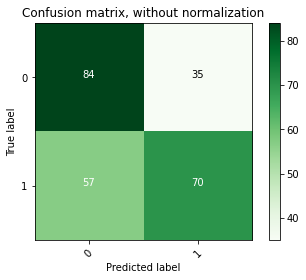

In [ ]:
y_actual=[]
y_pred=[]
for i in range(len(preds)):
  y_actual.append(np.argmax(y_test[i]))
  y_pred.append(np.argmax(preds[i]))
import matplotlib.pyplot as plt1
 

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt1.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
 
    plt1.imshow(cm, interpolation='nearest', cmap=cmap)
    plt1.title(title)
    plt1.colorbar()
    tick_marks = np.arange(len(classes))
    plt1.xticks(tick_marks, classes, rotation=45)
    plt1.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt1.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt1.ylabel('True label')
    plt1.xlabel('Predicted label')
    plt1.cm
    plt1.show()
cnf_matrix = confusion_matrix(y_actual, y_pred)
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt1.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      
                      title='Confusion matrix, without normalization')

# **BERT FEATURE EXTRACTION**

In [ ]:

!pip install tweet-preprocessor

In [ ]:
import os
# importing sys
import sys
sys.path.insert(0, '/content/personality-prediction')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import csv
import pickle
import re
import time
from datetime import timedelta
!pip install transformers
!pip install sentencepiece
import torch
from torch.utils.data import DataLoader, Dataset
#from transformers import *
import transformers
import preprocessor
import utils.gen_utils as utils
from utils.data_utils import MyMapDataset
import os
from pathlib import Path
from transformers import BertModel, AlbertModel, BertTokenizer
sys.path.insert(0, os.getcwd())
import numpy as np
import pandas as pd
import re
import csv
import preprocessor as p
import math

import numpy as np
import pandas as pd
import re
import csv
import preprocessor as p
from torch.utils.data import DataLoader, Dataset
import torch
#from transformers import *
import math

from utils.author_100recent import get_100_recent_posts
import utils.dataset_processors as dataset_processors
import numpy as np
import pandas as pd
import re
import csv
import preprocessor as p
import math


def preprocess_text(sentence):
    # remove hyperlinks, hashtags, smileys, emojies
    sentence = p.clean(sentence)
    # Remove hyperlinks
    sentence = re.sub(r"http\S+", " ", sentence)
    # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # sentence = re.sub('[^a-zA-Z.?!,]', ' ', sentence)
    # Single character removal (except I)
    # sentence = re.sub(r"\s+[a-zA-HJ-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = re.sub(r"\|\|\|", " ", sentence)

    return sentence


def load_essays_df(datafile):
    with open(datafile, "rt") as csvf:
        csvreader = csv.reader(csvf, delimiter=",", quotechar='"')
        first_line = True
        df = pd.DataFrame(
            columns=["user", "text", "token_len", "EXT", "NEU", "AGR", "CON", "OPN"]
        )
        for line in csvreader:
            if first_line:
                first_line = False
                continue

            text = line[1]
            df = df.append(
                {
                    "user": line[0],
                    "text": text,
                    "token_len": 0,
                    "EXT": 1 if line[2].lower() == "y" else 0,
                    "NEU": 1 if line[3].lower() == "y" else 0,
                    "AGR": 1 if line[4].lower() == "y" else 0,
                    "CON": 1 if line[5].lower() == "y" else 0,
                    "OPN": 1 if line[6].lower() == "y" else 0,
                },
                ignore_index=True,
            )

    print("EXT : ", df["EXT"].value_counts())
    print("NEU : ", df["NEU"].value_counts())
    print("AGR : ", df["AGR"].value_counts())
    print("CON : ", df["CON"].value_counts())
    print("OPN : ", df["OPN"].value_counts())

    return df


def essays_embeddings(datafile, tokenizer, token_length, mode):
    targets = []
    input_ids = []

    df = load_essays_df(datafile)
    cnt = 0

    # sorting all essays in ascending order of their length
    for ind in df.index:
        tokens = tokenizer.tokenize(df["text"][ind])
        df.at[ind, "token_len"] = len(tokens)

    df.sort_values(by=["token_len", "user"], inplace=True, ascending=True)
    tmp_df = df["user"]
    tmp_df.to_csv("/content/personality-prediction/data/essays/author_id_order.csv", index_label="order")
    print(df["token_len"].mean())

    for ii in range(len(df)):
        text = preprocess_text(df["text"][ii])
        tokens = tokenizer.tokenize(text)

        if mode == "normal" or mode == "512_head":
            input_ids.append(
                tokenizer.encode(
                    tokens,
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
            )
        elif mode == "512_tail":
            input_ids.append(
                tokenizer.encode(
                    tokens[-(token_length - 2) :],
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
            )
        elif mode == "256_head_tail":
            input_ids.append(
                tokenizer.encode(
                    tokens[: (token_length - 1)] + tokens[-(token_length - 1) :],
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
            )

        elif mode == "docbert":
            docmax_len = 2048
            subdoc_len = 512
            max_subdoc_num = docmax_len // subdoc_len
            subdoc_tokens = [
                tokens[i : i + subdoc_len] for i in range(0, len(tokens), subdoc_len)
            ][:max_subdoc_num]
            # print(subdoc_tokens)
            token_ids = [
                tokenizer.encode(
                    x,
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
                for x in subdoc_tokens
            ]
            # print(token_ids)
            token_ids = np.array(token_ids).astype(int)

            buffer_len = docmax_len // subdoc_len - token_ids.shape[0]
            # print(buffer_len)
            tmp = np.full(shape=(buffer_len, token_length), fill_value=0, dtype=int)
            token_ids = np.concatenate((token_ids, tmp), axis=0)

            input_ids.append(token_ids)

        targets.append(
            [df["EXT"][ii], df["NEU"][ii], df["AGR"][ii], df["CON"][ii], df["OPN"][ii]]
        )
        cnt += 1

    author_ids = np.array(df.index)
    print("loaded all input_ids and targets from the data file!")
    return author_ids, input_ids, targets


def load_Kaggle_df(datafile):
    with open(datafile, "rt", encoding="utf-8") as csvf:
        csvreader = csv.reader(csvf, delimiter=",", quotechar='"')
        first_line = True
        df = pd.DataFrame(columns=["user", "text", "E", "N", "F", "J"])
        for line in csvreader:
            if first_line:
                first_line = False
                continue

            text = line[1]

            df = df.append(
                {
                    "user": line[3],
                    "text": text,
                    "E": 1 if line[0][0] == "E" else 0,
                    "N": 1 if line[0][1] == "N" else 0,
                    "F": 1 if line[0][2] == "F" else 0,
                    "J": 1 if line[0][3] == "J" else 0,
                },
                ignore_index=True,
            )

    print("E : ", df["E"].value_counts())
    print("N : ", df["N"].value_counts())
    print("F : ", df["F"].value_counts())
    print("J : ", df["J"].value_counts())

    return df


def kaggle_embeddings(datafile, tokenizer, token_length):
    hidden_features = []
    targets = []
    token_len = []
    input_ids = []
    author_ids = []

    df = load_Kaggle_df(datafile)
    cnt = 0
    for ind in df.index:

        text = preprocess_text(df["text"][ind])
        tokens = tokenizer.tokenize(text)
        token_len.append(len(tokens))
        token_ids = tokenizer.encode(
            tokens,
            add_special_tokens=True,
            max_length=token_length,
            pad_to_max_length=True,
        )
        if cnt < 10:
            print(tokens[:10])

        input_ids.append(token_ids)
        targets.append([df["E"][ind], df["N"][ind], df["F"][ind], df["J"][ind]])
        author_ids.append(int(df["user"][ind]))
        cnt += 1

    print("average length : ", int(np.mean(token_len)))
    author_ids = np.array(author_ids)

    return author_ids, input_ids, targets


class MyMapDataset(Dataset):
    def __init__(self, dataset, tokenizer, token_length, DEVICE, mode):
        if dataset == "essays":
            datafile = "/content/personality-prediction/data/essays/essays.csv"
            author_ids, input_ids, targets = essays_embeddings(
                datafile, tokenizer, token_length, mode
            )
        elif dataset == "kaggle":
            datafile = "/content/personality-prediction/data/kaggle/kaggle.csv"
            author_ids, input_ids, targets = kaggle_embeddings(
                datafile, tokenizer, token_length
            )
        elif dataset == "pandora":
            author_ids, input_ids, targets = pandora_embeddings(
                datafile, tokenizer, token_length
            )

        author_ids = torch.from_numpy(np.array(author_ids)).long().to(DEVICE)
        input_ids = torch.from_numpy(np.array(input_ids)).long().to(DEVICE)
        targets = torch.from_numpy(np.array(targets))

        if dataset == "pandora":
            targets = targets.float().to(DEVICE)
        else:
            targets = targets.long().to(DEVICE)

        self.author_ids = author_ids
        self.input_ids = input_ids
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (self.author_ids[idx], self.input_ids[idx], self.targets[idx])

def preprocess_text(sentence):
    # remove hyperlinks, hashtags, smileys, emojies
    sentence = p.clean(sentence)
    # Remove hyperlinks
    sentence = re.sub(r"http\S+", " ", sentence)
    # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # sentence = re.sub('[^a-zA-Z.?!,]', ' ', sentence)
    # Single character removal (except I)
    # sentence = re.sub(r"\s+[a-zA-HJ-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = re.sub(r"\|\|\|", " ", sentence)

    return sentence


def load_essays_df(datafile):
    with open(datafile, "rt") as csvf:
        csvreader = csv.reader(csvf, delimiter=",", quotechar='"')
        first_line = True
        df = pd.DataFrame(
            columns=["user", "text", "token_len", "EXT", "NEU", "AGR", "CON", "OPN"]
        )
        for line in csvreader:
            if first_line:
                first_line = False
                continue

            text = line[1]
            df = df.append(
                {
                    "user": line[0],
                    "text": text,
                    "token_len": 0,
                    "EXT": 1 if line[2].lower() == "y" else 0,
                    "NEU": 1 if line[3].lower() == "y" else 0,
                    "AGR": 1 if line[4].lower() == "y" else 0,
                    "CON": 1 if line[5].lower() == "y" else 0,
                    "OPN": 1 if line[6].lower() == "y" else 0,
                },
                ignore_index=True,
            )

    print("EXT : ", df["EXT"].value_counts())
    print("NEU : ", df["NEU"].value_counts())
    print("AGR : ", df["AGR"].value_counts())
    print("CON : ", df["CON"].value_counts())
    print("OPN : ", df["OPN"].value_counts())

    return df


def essays_embeddings(datafile, tokenizer, token_length, mode):
    targets = []
    input_ids = []

    df = load_essays_df(datafile)
    cnt = 0

    # sorting all essays in ascending order of their length
    for ind in df.index:
        tokens = tokenizer.tokenize(df["text"][ind])
        df.at[ind, "token_len"] = len(tokens)

    df.sort_values(by=["token_len", "user"], inplace=True, ascending=True)
    tmp_df = df["user"]
    tmp_df.to_csv("/content/personality-prediction/data/essays/author_id_order.csv", index_label="order")
    print(df["token_len"].mean())

    for ii in range(len(df)):
        text = preprocess_text(df["text"][ii])
        tokens = tokenizer.tokenize(text)

        if mode == "normal" or mode == "512_head":
            input_ids.append(
                tokenizer.encode(
                    tokens,
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
            )
        elif mode == "512_tail":
            input_ids.append(
                tokenizer.encode(
                    tokens[-(token_length - 2) :],
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
            )
        elif mode == "256_head_tail":
            input_ids.append(
                tokenizer.encode(
                    tokens[: (token_length - 1)] + tokens[-(token_length - 1) :],
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
            )

        elif mode == "docbert":
            docmax_len = 2048
            subdoc_len = 512
            max_subdoc_num = docmax_len // subdoc_len
            subdoc_tokens = [
                tokens[i : i + subdoc_len] for i in range(0, len(tokens), subdoc_len)
            ][:max_subdoc_num]
            # print(subdoc_tokens)
            token_ids = [
                tokenizer.encode(
                    x,
                    add_special_tokens=True,
                    max_length=token_length,
                    pad_to_max_length=True,
                )
                for x in subdoc_tokens
            ]
            # print(token_ids)
            token_ids = np.array(token_ids).astype(int)

            buffer_len = docmax_len // subdoc_len - token_ids.shape[0]
            # print(buffer_len)
            tmp = np.full(shape=(buffer_len, token_length), fill_value=0, dtype=int)
            token_ids = np.concatenate((token_ids, tmp), axis=0)

            input_ids.append(token_ids)

        targets.append(
            [df["EXT"][ii], df["NEU"][ii], df["AGR"][ii], df["CON"][ii], df["OPN"][ii]]
        )
        cnt += 1

    author_ids = np.array(df.index)
    print("loaded all input_ids and targets from the data file!")
    return author_ids, input_ids, targets


def load_Kaggle_df(datafile):
    with open(datafile, "rt", encoding="utf-8") as csvf:
        csvreader = csv.reader(csvf, delimiter=",", quotechar='"')
        first_line = True
        df = pd.DataFrame(columns=["user", "text", "E", "N", "F", "J"])
        for line in csvreader:
            if first_line:
                first_line = False
                continue

            text = line[1]

            df = df.append(
                {
                    "user": line[3],
                    "text": text,
                    "E": 1 if line[0][0] == "E" else 0,
                    "N": 1 if line[0][1] == "N" else 0,
                    "F": 1 if line[0][2] == "F" else 0,
                    "J": 1 if line[0][3] == "J" else 0,
                },
                ignore_index=True,
            )

    print("E : ", df["E"].value_counts())
    print("N : ", df["N"].value_counts())
    print("F : ", df["F"].value_counts())
    print("J : ", df["J"].value_counts())

    return df


def kaggle_embeddings(datafile, tokenizer, token_length):
    hidden_features = []
    targets = []
    token_len = []
    input_ids = []
    author_ids = []

    df = load_Kaggle_df(datafile)
    cnt = 0
    for ind in df.index:

        text = preprocess_text(df["text"][ind])
        tokens = tokenizer.tokenize(text)
        token_len.append(len(tokens))
        token_ids = tokenizer.encode(
            tokens,
            add_special_tokens=True,
            max_length=token_length,
            pad_to_max_length=True,
        )
        if cnt < 10:
            print(tokens[:10])

        input_ids.append(token_ids)
        targets.append([df["E"][ind], df["N"][ind], df["F"][ind], df["J"][ind]])
        author_ids.append(int(df["user"][ind]))
        cnt += 1

    print("average length : ", int(np.mean(token_len)))
    author_ids = np.array(author_ids)

    return author_ids, input_ids, targets

start = time.time()

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("GPU found (", torch.cuda.get_device_name(torch.cuda.current_device()), ")")
    torch.cuda.set_device(torch.cuda.current_device())
    print("num device avail: ", torch.cuda.device_count())

else:
    DEVICE = torch.device("cpu")
    print("running on cpu")


def extract_bert_features(input_ids, mode, n_hl):
    """Extract bert embedding for each input."""
    if mode == "docbert":
        # print(input_ids.shape)
        tmphidden_features = []
        input_ids = input_ids.permute(1, 0, 2)

        for jj in range(input_ids.shape[0]):
            tmp = []
            if input_ids[jj][0][0] == 0:
                break

            bert_output = model(input_ids[jj])
            for ii in range(n_hl):
                if embed_mode == "mean":
                    tmp.append((bert_output[2][ii + 1].cpu().numpy()).mean(axis=1))
                elif embed_mode == "cls":
                    tmp.append(bert_output[2][ii + 1][:, 0, :].cpu().numpy())

            tmphidden_features.append(tmp)

        tmphidden_features = np.array(tmphidden_features)
        hidden_features.append(tmphidden_features.mean(axis=0))

    else:
        tmp = []
        bert_output = model(input_ids)
        # bert_output[2](this id gives all BERT outputs)[ii+1](which BERT layer)[:,0,:](taking the <CLS> output)

        for ii in range(n_hl):
            if embed_mode == "cls":
                tmp.append(bert_output[2][ii + 1][:, 0, :].cpu().numpy())
            elif embed_mode == "mean":
                tmp.append((bert_output[2][ii + 1].cpu().numpy()).mean(axis=1))

        hidden_features.append(np.array(tmp))
        return hidden_features


def get_model(embed):
    # * Model          | Tokenizer          | Pretrained weights shortcut
    # MODEL=(DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    if embed == "bert-base":
        n_hl = 12
        hidden_dim = 768
        MODEL = (BertModel, BertTokenizer, "bert-base-uncased")

    elif embed == "bert-large":
        n_hl = 24
        hidden_dim = 1024
        MODEL = (BertModel, BertTokenizer, "bert-large-uncased")

    elif embed == "albert-base":
        n_hl = 12
        hidden_dim = 768
        MODEL = (AlbertModel, AlbertTokenizer, "albert-base-v2")

    elif embed == "albert-large":
        n_hl = 24
        hidden_dim = 1024
        MODEL = (AlbertModel, AlbertTokenizer, "albert-large-v2")

    model_class, tokenizer_class, pretrained_weights = MODEL

    # load the LM model and tokenizer from the HuggingFace Transformers library
    model = model_class.from_pretrained(
        pretrained_weights, output_hidden_states=True
    )  # output_attentions=False
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=True)

    return model, tokenizer, n_hl, hidden_dim


if __name__ == "__main__":
    sys.argv=['']
    del sys
    # argument extractor
    (
        dataset,
        token_length,
        batch_size,
        embed,
        op_dir,
        mode,
        embed_mode,
    ) = utils.parse_args_extractor()
    print(
        "{} | {} | {} | {} | {}".format(dataset, embed, token_length, mode, embed_mode)
    )
    batch_size = int(32)
    model, tokenizer, n_hl, hidden_dim = get_model(embed)

    # create a class which can be passed to the pyTorch dataloader. responsible for returning tokenized and encoded values of the dataset
    # this class will have __getitem__(self,idx) function which will return input_ids and target values

    map_dataset = MyMapDataset(dataset, tokenizer, token_length, DEVICE, mode)

    data_loader = DataLoader(
        dataset=map_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    if DEVICE == torch.device("cuda"):
        model = model.cuda()
        # model.parameters() returns a generator obj
        # print('model loaded to gpu? ', next(model.parameters()).is_cuda)
        print(
            "\ngpu mem alloc: ", round(torch.cuda.memory_allocated() * 1e-9, 2), " GB"
        )

    print("starting to extract LM embeddings...")

    hidden_features = []
    all_targets = []
    all_author_ids = []

    # get bert embedding for each input
    for author_ids, input_ids, targets in data_loader:
        with torch.no_grad():
            all_targets.append(targets.cpu().numpy())
            all_author_ids.append(author_ids.cpu().numpy())
            extract_bert_features(input_ids, mode, n_hl)

    Path(op_dir).mkdir(parents=True, exist_ok=True)
    pkl_file_name = dataset + "-" + embed + "-" + embed_mode + "-" + mode + ".pkl"

    file = open(os.path.join(op_dir, pkl_file_name), "wb")
    pickle.dump(zip(all_author_ids, hidden_features, all_targets), file)
    file.close()

    # print(timedelta(seconds=int(time.time() - start)), end=' ')
    print("extracting embeddings for {} dataset: DONE!".format(dataset))


     |████████████████████████████████| 3.4 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 47.8 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 3.3 MB 32.9 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.1 MB/s 
GPU found ( Tesla K80 )
num device avail:  1
essays | bert-base | 512 | 512_head | cls


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

EXT :  1    1275
0    1192
Name: EXT, dtype: int64
NEU :  1    1234
0    1233
Name: NEU, dtype: int64
AGR :  1    1309
0    1158
Name: AGR, dtype: int64
CON :  1    1254
0    1213
Name: CON, dtype: int64
OPN :  1    1271
0    1196
Name: OPN, dtype: int64


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


787.5030401297122


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


loaded all input_ids and targets from the data file!

gpu mem alloc:  0.45  GB
starting to extract LM embeddings...
extracting embeddings for essays dataset: DONE!


# **Personality Prediction using BERT Features**

In [ ]:
import os
import sys

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import numpy as np
import re
import pickle
import time
import pandas as pd
from pathlib import Path

# add parent directory to the path as well, if running from the finetune folder
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)

sys.path.insert(0, os.getcwd())

import utils.gen_utils as utils


def get_inputs(inp_dir, dataset, embed, embed_mode, mode, layer):
    """Read data from pkl file and prepare for training."""
    file = open(
        inp_dir + dataset + "-" + embed + "-" + embed_mode + "-" + mode + ".pkl", "rb"
    )
    data = pickle.load(file)
    author_ids, data_x, data_y = list(zip(*data))
    file.close()

    # alphaW is responsible for which BERT layer embedding we will be using
    if layer == "all":
        alphaW = np.full([n_hl], 1 / n_hl)

    else:
        alphaW = np.zeros([n_hl])
        alphaW[int(layer) - 1] = 1

    # just changing the way data is stored (tuples of minibatches) and
    # getting the output for the required layer of BERT using alphaW
    inputs = []
    targets = []
    n_batches = len(data_y)
    for ii in range(n_batches):
        inputs.extend(np.einsum("k,kij->ij", alphaW, data_x[ii]))
        targets.extend(data_y[ii])

    inputs = np.array(inputs)
    full_targets = np.array(targets)

    return inputs, full_targets


def training(dataset, inputs, full_targets):
    """Train MLP model for each trait on 10-fold corss-validtion."""
    if dataset == "kaggle":
        trait_labels = ["E", "N", "F", "J"]
    else:
        trait_labels = ["EXT", "NEU", "AGR", "CON", "OPN"]

    n_splits = 10
    fold_acc = {}
    expdata = {}
    expdata["acc"], expdata["trait"], expdata["fold"] = [], [], []

    for trait_idx in range(full_targets.shape[1]):
        # convert targets to one-hot encoding
        targets = full_targets[:, trait_idx]
        n_data = targets.shape[0]

        expdata["trait"].extend([trait_labels[trait_idx]] * n_splits)
        expdata["fold"].extend(np.arange(1, n_splits + 1))

        skf = StratifiedKFold(n_splits=n_splits, shuffle=False)
        k = -1
        for train_index, test_index in skf.split(inputs, targets):
            x_train, x_test = inputs[train_index], inputs[test_index]
            y_train, y_test = targets[train_index], targets[test_index]
            # converting to one-hot embedding
            y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
            y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
            model = tf.keras.models.Sequential()

            # define the neural network architecture
            model.add(
                tf.keras.layers.Dense(50, input_dim=hidden_dim, activation="relu")
            )
            model.add(tf.keras.layers.Dense(n_classes))

            k += 1
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["mse", "accuracy"],
            )

            history = model.fit(
                x_train,
                y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, y_test),
                verbose=0,
            )

            expdata["acc"].append(100 * max(history.history["val_accuracy"]))
    print(expdata)
    df = pd.DataFrame.from_dict(expdata)
    preds=model.predict(x_test)
    return df,preds,y_test


def logging(df, log_expdata=True):
    """Save results and each models config and hyper parameters."""
    (
        df["network"],
        df["dataset"],
        df["lr"],
        df["batch_size"],
        df["epochs"],
        df["model_input"],
        df["embed"],
        df["layer"],
        df["mode"],
        df["embed_mode"],
        df["jobid"],
    ) = (
        network,
        dataset,
        lr,
        batch_size,
        epochs,
        MODEL_INPUT,
        embed,
        layer,
        mode,
        embed_mode,
        jobid,
    )

    pd.set_option("display.max_columns", None)
    print(df.head(5))

    # save the results of our experiment
    if log_expdata:
        Path(path).mkdir(parents=True, exist_ok=True)
        if not os.path.exists(path + "expdata.csv"):
            df.to_csv(path + "expdata.csv", mode="a", header=True)
        else:
            df.to_csv(path + "expdata.csv", mode="a", header=False)


if __name__ == "__main__":
    (
        inp_dir,
        dataset,
        lr,
        batch_size,
        epochs,
        log_expdata,
        embed,
        layer,
        mode,
        embed_mode,
        jobid,
    ) = utils.parse_args()
    # embed_mode {mean, cls}
    # mode {512_head, 512_tail, 256_head_tail}

    network = "MLP"
    MODEL_INPUT = "LM_features"
    print("{} : {} : {} : {} : {}".format(dataset, embed, layer, mode, embed_mode))
    n_classes = 2
    seed = jobid
    np.random.seed(seed)
    tf.random.set_seed(seed)

    start = time.time()
    path = "explogs/"

    if re.search(r"base", embed):
        n_hl = 12
        hidden_dim = 768

    elif re.search(r"large", embed):
        n_hl = 24
        hidden_dim = 1024

    inputs, full_targets = get_inputs(inp_dir, dataset, embed, embed_mode, mode, layer)
    df,preds,y_test = training(dataset, inputs, full_targets)
    logging(df, log_expdata)


essays : bert-base : 11 : 512_head : cls
{'acc': [58.70445370674133, 57.894736528396606, 57.894736528396606, 58.29959511756897, 56.27530217170715, 55.46558499336243, 55.06072640419006, 56.91056847572327, 58.94308686256409, 54.878050088882446, 56.27530217170715, 52.63158082962036, 55.87044358253479, 61.94332242012024, 61.13360524177551, 59.109312295913696, 61.13360524177551, 52.84552574157715, 54.47154641151428, 59.34959053993225, 53.44129800796509, 61.538463830947876, 59.51417088508606, 55.06072640419006, 61.13360524177551, 56.68016076087952, 58.29959511756897, 57.723575830459595, 61.38211488723755, 63.008129596710205, 52.226722240448, 58.70445370674133, 59.51417088508606, 61.538463830947876, 57.894736528396606, 62.75303363800049, 56.27530217170715, 60.16260385513306, 54.06504273414612, 58.13007950782776, 60.72874665260315, 64.7773265838623, 66.80161952972412, 66.39676094055176, 59.51417088508606, 64.37246799468994, 64.7773265838623, 64.63414430618286, 62.60162591934204, 61.78861856460

Confusion matrix, without normalization


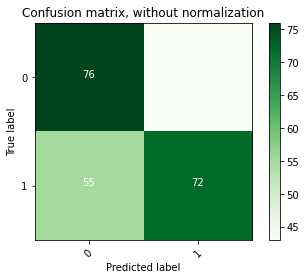

In [ ]:
y_actual=[]
y_pred=[]
for i in range(len(preds)):
  y_actual.append(np.argmax(y_test[i]))
  y_pred.append(np.argmax(preds[i]))
import matplotlib.pyplot as plt1
 

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt1.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
 
    plt1.imshow(cm, interpolation='nearest', cmap=cmap)
    plt1.title(title)
    plt1.colorbar()
    tick_marks = np.arange(len(classes))
    plt1.xticks(tick_marks, classes, rotation=45)
    plt1.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt1.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt1.ylabel('True label')
    plt1.xlabel('Predicted label')
    plt1.cm
    plt1.show()
cnf_matrix = confusion_matrix(y_actual, y_pred)
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt1.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      
                      title='Confusion matrix, without normalization')